Auto-Encoding. Define a convolutional autoencoder to encode (and decode) the images into a small dimensional latent space d (around d=10) containing no spatial structure (1x1xd tensors). Explore the reconstruction error over the test set when (i): using low and high latent space dimension d, and (ii) using a fixed d yet different architecture with more and less layers (/weights). Report these tests and the best score obtained (i.e. plot your results as a function of the different experiments performed). The best practice of implementing this code is by defining an Encoder and a Decoder as separate Pytorch modules.



In [3]:
import torch
import torchvision
import torchvision.transforms as transforms

import matplotlib.pyplot as plt # plotting library
import numpy as np # this module is useful to work with numerical arrays
import pandas as pd 
import random 
import torch
import torchvision
from torchvision import transforms, datasets
from torch.utils.data import DataLoader,random_split
from torch import nn
import torch.nn.functional as F
import torch.optim as optim



from torch.nn.modules.conv import ConvTranspose2d
from torch.nn.modules.flatten import Unflatten
from os import truncate
from torch.nn.modules.activation import ReLU
from torch.nn.modules.container import Sequential


In [4]:
transform = transforms.Compose(
    [transforms.ToTensor()])

batch_size =16

trainset = datasets.MNIST(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

testset = datasets.MNIST(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2) 


Balance of data

In [ ]:
# total = 0
# counter_dict = {0:0, 1:0, 2:0, 3:0, 4:0, 5:0, 6:0, 7:0, 8:0, 9:0}


# for data in trainloader:
#     Xs, ys = data
#     for y in ys:
#         counter_dict[int(y)] += 1
#         total += 1

# print(counter_dict)

# for i in counter_dict:
#     print(f"{i}: {counter_dict[i]/total*100.0}%")

defining encoder and decorder classes


In [ ]:
from torch.nn.modules.conv import ConvTranspose2d
from torch.nn.modules.flatten import Unflatten
from os import truncate
from torch.nn.modules.activation import ReLU
from torch.nn.modules.container import Sequential

#BASELINE ENCODER MODEL 

class Encoder(nn.Module):
    def __init__(self,latenSpace_dim):
        super().__init__()
        #conv
        self.encoder_cnn = nn.Sequential(
          nn.Conv2d(1,32,3,stride =2, padding = 1),
          nn.ReLU(True),
          nn.Conv2d(32, 64, 3, stride=2, padding = 1),
          nn.BatchNorm2d(num_features=64),
          nn.ReLU(True),                                 #relu before batch noormalization
          nn.Conv2d(64,128,3, stride =2, padding = 0),  #reduce quite drastically the image (3 by 3) before using fC layers to get vector
          nn.ReLU(True)
        )
         
        #flattern
        self.flat = nn.Flatten(start_dim=1)
        
        #linear  
        self.encoder_lin = nn.Sequential(
          nn.Linear(128 * 3 * 3,128), 
          nn.ReLU(True),
          nn.Linear(128,latenSpace_dim) 
        )
    
    def forward(self, x):
        
        x = self.encoder_cnn(x)
        x = self.flat(x)
        x = self.encoder_lin(x)
        return x

# BASELINE DECODER  --> symetric to encoder model
class Decoder(nn.Module):
    def __init__(self,latenSpace_dim):
      super().__init__()
      #linear 
      self.decoder_lin = nn.Sequential(
        nn.Linear(latenSpace_dim,128),
        nn.ReLU(True), 
        nn.Linear(128,128*3*3), 
        nn.ReLU(True)
      )
      #unflattern
      self.unflat = nn.Unflatten(dim=1, unflattened_size=(128,3,3))
      
      #conv
      #here I inversed the batch_norm and relu layers and added one batch norm
      self.decoder_cnn = nn.Sequential(
        nn.ConvTranspose2d(128,64,3,stride=2, padding= 0, output_padding =0), #why output padding is zero here? what does outputpadding does?
        nn.BatchNorm2d(num_features=64),
        nn.ReLU(True),
        nn.ConvTranspose2d(64,32,3,stride =2, padding =1, output_padding =1),
        nn.BatchNorm2d(num_features = 32),
        nn.ReLU(True),
        nn.ConvTranspose2d(32, 1, 3, stride=2, padding=1, output_padding=1)

      )

    def forward(self, x):
      x = self.decoder_lin(x)
      x = self.unflat(x)
      x = self.decoder_cnn(x)
      return x

      
        

In [ ]:
import torch.optim as optim
d= 5
encoder = Encoder(latenSpace_dim=5)
decoder = Decoder(latenSpace_dim=5)

parameters_to_opt = [                                                            #how do i do it the iterable way? see adam doc
    {'params': encoder.parameters()},
    {'params': decoder.parameters()}
]


loss_funk = torch.nn.HuberLoss()                                                       
optimizer = optim.Adam(parameters_to_opt,lr=0.016,weight_decay=1e-05)         #what is weight decay??


In [ ]:
def train_epoch(encoder, decoder,dataloader,loss_funk,optimizer):
  encoder.train()
  decoder.train()
  losses = 0
  for batch in trainloader:
    data, true_labels = batch
    #Forward pass
    new_data = decoder(encoder(data))        

    #Calculating loss
    loss = loss_funk(data,new_data)   

    #Backward pass
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    losses += loss.item()
  losses = losses/len(trainloader)
  return losses


def test_epoch(encoder, decoder,dataloader,loss_function,optimizer):
  encoder.eval()
  decoder.eval()
  losses = 0
  with torch.no_grad():
    for batch in testloader:
      data, true_labels = batch
      new_data = decoder(encoder(data)) 
      loss = loss_funk(data,new_data)                                        
      losses += loss.item()
  losses = losses/len(testloader)
  return losses
  


235
epoch number :1
235
epoch number :2
235
epoch number :3
235
epoch number :4
235
epoch number :5
235
epoch number :6
235
epoch number :7
0.013583975804454468
0.013396198675036431


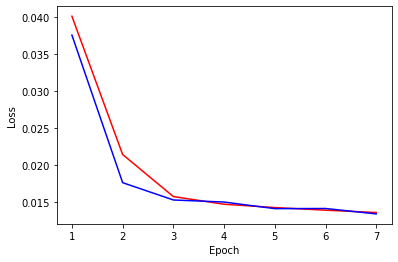

Finished Training


In [ ]:

EPOCH = 7
train_loss =[]
test_loss =[]
epoch_number =0

for epoch in range(EPOCH):  # loop over the dataset multiple times
  #training
  epoch_train_loss = train_epoch(encoder,decoder,trainloader,loss_funk,optimizer)
  train_loss.append(epoch_train_loss)

  #testing
  epoch_test_loss = test_epoch(encoder,decoder,testloader,loss_funk,optimizer)
  test_loss.append(epoch_test_loss)
  epoch_number += 1
  print('epoch number :'+ str(epoch_number))
  
  #plotting last losses
  if epoch == EPOCH-1:
    print(epoch_train_loss)
    print(epoch_test_loss)
  
#plotting training and testing loss
x = np.linspace(1,EPOCH,EPOCH).astype(int)
y_train = np.array(train_loss)
y_test = np.array(test_loss)

plt.plot(x,y_train, 'r')
plt.plot(x,y_test,'b')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()


print('Finished Training')







Interpolation. Once you have a trained the AE, you can use it to interpolate between two digits in latent space. That is, let I1 and I2 be two different digits, perform the interpolation D((E(I1)*)+(E(I2)*(1-))) for a=0...1 where D denotes the decoder and E the encoder. (i) Include the gradual images obtained. (ii) Try different pairs of digits. (iii) Try repeating this operation with an AE trained using a higher embedding dimension d~20. (iv) Which is better? Provide an explanation why the quality increased or decreased.

In [ ]:

#interpolation check of our AE
#sample two images from data
from plotly.subplots import make_subplots
import plotly.graph_objects as go
from skimage import io 
import plotly.express as px

def interpolate(encoder,decoder,im1,im2,alpha):
  laten_vec1 = encoder(im1)
  laten_vec2 = encoder(im2)
  interpolation = decoder((laten_vec1 * alpha) + (laten_vec2 * (1-alpha)))
  return interpolation


encoder.eval()
decoder.eval()

for batch in testloader:
  data, labels = batch
  break


im1, im2  = data[13], data[21]        
im1, im2 = torch.unsqueeze(im1,0), torch.unsqueeze(im2,0)    
                                       #chose two images from batch size (batch size is shuffled)

                                                  #chose 10 alph values linearly spaced
new_images = []
for alpha in np.linspace(0,1,10):  
  new_image = interpolate(encoder,decoder,im1,im2,alpha).detach().squeeze().numpy()
  new_images.append(new_image)

 # reconstruct images from the chosen laten vectors



im1 = im1.detach().numpy().squeeze()
im2 = im2.detach().numpy().squeeze()
initial_ims = np.array([im1,im2])

new_images = np.array(new_images)
print(len(new_images))
print(new_images[0].dtype)
fig1 = px.imshow(new_images, facet_col=0)
fig2 = px.imshow(initial_ims,facet_col=0)

fig1.show()
fig2.show()



           
           

Decorrelation. In the following experiment we will investigate the connection between dimensional reduction and dependencies (/redundancies) in the representation. Carry this out by computing the Pearson correlations between different coordinates of the latent codes (based on a few thousands encoded images), and use them to come up with a single value (that you came up with!) for measuring the overall correlation. Plot this value with respect to the latent space dimension d (over at least 4 values of d). Explain your choices and the trend in correlation versus d that you observe. Provide an explanation in your report.


In [ ]:
from numpy.lib.function_base import cov
#Decorrelation
#dimensional reduction Vs dependencies in laten-Space
from scipy.linalg import null_space
COUNT = 256
#method 1
# encoder.eval()
# with torch.no_grad():
#   count =0 
#   laten_vecs = []
#   for batch in testset:
#     image,_ = batch
#     image = image[None,:]
#     laten_vecs.append(np.array(encoder(image)))
#     count+=1
#     if count ==COUNT:
#       break

# laten_vecs = np.array(laten_vecs).squeeze()
# print(laten_vecs.shape)


#method 2
encoder.eval()
with torch.no_grad():
  for batch in testloader:
    data,_ = batch
    laten_vecs = np.array(encoder(data))
    break  


print(laten_vecs.shape)

corr_matrix = np.corrcoef(laten_vecs)

print(corr_matrix.shape)

#method 0 - Take mean of rows for each matrix in array. we then take again the mean.
new_matrix = corr_matrix - (np.eye(COUNT) * np.diag(corr_matrix))
mean_rows_vec = np.mean(new_matrix, axis = 0)
mean_corr_estimate = np.mean(mean_rows_vec) 
print('mean_corr_estimate: ' + str(mean_corr_estimate))                                                                   #mean 1  - np.eye(256)@ np.diag(x)


#method 1 -eigen value of zero tells us that there is linear dependency and thus redudencies in the data. (look at eeigen space of zero)

cov_matrix = np.cov(laten_vecs)
null_dim = null_space(cov_matrix).shape[1]
print('dim of null space: '+ str(null_dim))

# #method 2 - calculate the determinant of the matrix 
det_corr = np.linalg.det(corr_matrix)
print('det of correlation matrix:'+ str(det_corr))


# #method 3 - orthogonally project each column of matrix onto the same space and calculate mean/corr on these vectors
  

# EPOCH =2
# def get_all_laten_vectors(encoder,testloader):
#   encoder.eval()
#   total_laten_vectors = []
#   with torch.no_grad():
#     for batch in testloader:
#       data,_ = batch
#       laten_vectors = np.array(encoder(data))
#       total_laten_vectors.append(laten_vectors)
#       break  #TODO: how to run multiple times? when i remove break i get only 16 samples
      
#   return laten_vectors # lists of images
  

# laten_vectors = get_all_laten_vectors(encoder,testloader)
# print(laten_vectors.shape


#TODO: cant understad why this is wrong !!
# encoder.eval()
# with torch.no_grad():
#   for data in testloader:
#     images, labels = data
#     laten_vecs = np.array(encoder(images)).T
#     break
# print(laten_vecs.shape)
# laten_vecs = np.apply_along_axis(lambda x: np.corrcoef(x),axis= 0, arr= laten_vecs)
# print(laten_vecs.shape)
# print(laten_vecs[0].shape)
# #method 0 - Take mean of rows for each matrix in array. we then take again the mean. 
# # new_matrix = corr_matrix - np.eye(256)* np.diag(corr_matrix)  

# mean_vec = np.apply_along_axis(lambda x: np.mean(x),axis= 0, arr= laten_vecs) #mean 1  - np.eye(256)@ np.diag(x)
# mean_vec = np.apply_along_axis(lambda x: np.mean(x),axis= 0, arr= mean_vec) #mean2 represents an array with the internal correlation of each of the laten vectors extracted.


# #method 1 -eigen value of zero tells us that there is linear dependency and thus redudencies in the data. (look at eeigen space of zero)

# dim_vec = np.apply_along_axis(lambda x: np.cov(x),axis= 0, arr= laten_vecs)
# null_dim = np.apply_along_axis(lambda x: len(null_space(x)),axis= 0, arr= laten_vecs)

# #method 2 - calculate the determinant of the matrix 
# det_corr_vec = np.apply_along_axis(lambda x: np.linalg.det(x),axis= 0, arr= laten_vecs)
# print('det:'+ str(det_corr_vec[0]))


# #method 3 - orthogonally project each column of matrix onto the same space and calculate mean/corr on these vectors
  



# corr_matrix = np.corrcoef(laten_vectors)

# #method 0 - Take mean of either rows or columns (corr is symmetric) to get an array. Take mean of subsequent array.
# # new_matrix = corr_matrix - np.eye(256)* np.diag(corr_matrix)  
# mean_array = np.mean(new_matrix,axis=0) #mean of each row 
# mean_corr_val = np.mean(mean_array, axis =0)
# print(mean_corr_val)

# #method 1 -eigen value of zero tells us that there is linear dependency and thus redudencies in the data. (look at eeigen space of zero)
# cov_matrix = np.cov(laten_vectors)
# null_dim = len(null_space(cov_matrix))
# print('dim of null space: '+ str(null_dim ))

# #method 2 - calculate the determinant of the matrix 
# #The determinant of the correlation matrix will equal 1.0 only if all correlations equal 0. Otherwise the determinant will be less than 1.

# det = np.linalg.det(corr_matrix)
# print('det:'+ str(det)) #TODO: dont get why det is zero and null sapce 256 !!!


# #method 3 - orthogonally project each column of matrix onto the same space and calculate mean/corr on these vectors
  



Transfer Learning. Use a pre-trained encoder as a fixed network (i.e. excuse its weights from the following training optimization), and attach it to a small MLP (in latent space) and train only the latter to classify the digits (recall that MNIST is labeled). Do this with a small fraction of the labels in the dataset (~tens of images). Compare the performance of this solution next to the option of training the entire network (i.e., allow the encoder weights to train as well as the classification MLP) over this small number of training examples. Note that both training schemes used the same number of labels. Which option operated best? Report all the choices made (e.g., latent space dimension, MLP arch., and number of labels used, etc.), and the results obtained by each of the two training approaches.

epoch number :1
epoch number :2
epoch number :3
epoch number :4
epoch number :5
epoch number :6
epoch number :7
epoch number :9
epoch number :10
0.5832924279178444
0.6219805637762882


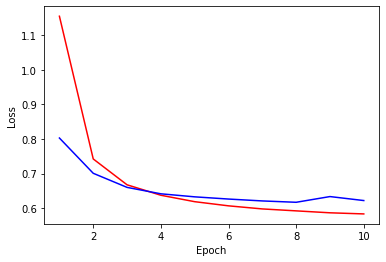

Finished Training


In [21]:
#transfer learning:
# #Encoder FatMan model
class Encoder(nn.Module):
    def __init__(self,latenSpace_dim):
        super().__init__()
        #conv
        self.encoder_cnn = nn.Sequential(
          nn.Conv2d(1,32,3,stride =2, padding = 1),
          nn.ReLU(True),
          nn.Conv2d(32, 64, 3, stride=2, padding = 1),
          nn.BatchNorm2d(num_features=64),
          nn.ReLU(True),                                 #relu before batch noormalization
          nn.Conv2d(64,128,3, stride =2, padding = 0),  #reduce quite drastically the image (3 by 3) before using fC layers to get vector
          nn.ReLU(True)
        )
         
        #flattern
        self.flat = nn.Flatten(start_dim=1)
        
        #linear  
        self.encoder_lin = nn.Sequential(
          nn.Linear(128 * 3 * 3,128), 
          nn.ReLU(True),
          nn.Linear(128,latenSpace_dim) 
        )
    
    def forward(self, x):
        
        x = self.encoder_cnn(x)
        x = self.flat(x)
        x = self.encoder_lin(x)
        return x

#creating a small Multi Layer Perceptron 


#helper function
def get_subset(size,testset):
  train_set =[] #set of batchs based on batchsize
  count =0 
  for batch in testloader:
   data, labels = batch[0], batch[1]
   train_data = data[:size,:,:,:]
   train_labels = labels[:size]
  return [train_data,train_labels]


EPOCH = 10
LATEN_DIM =5 #size of laten space 

class MLP(nn.Module):
    def __init__(self,latenSpace_dim):
        super().__init__()
          #linear 
        self.MLP_lin = nn.Sequential(
          nn.Linear(latenSpace_dim,32),
          nn.ReLU(True), 
          nn.Linear(32,64), 
          nn.ReLU(True),
          ####### symmetric side from decoder FatMan
          nn.Linear(64,64), 
          nn.ReLU(True),
          nn.Linear(64,10))
   
    def forward(self, x):

        x = self.MLP_lin(x)
        return x


#calling models, loss function, optimizer, 


# encoder = Encoder(latenSpace_dim=4)
mlp = MLP(latenSpace_dim=LATEN_DIM)
encoder = Encoder(latenSpace_dim=LATEN_DIM)
parameters_to_opt = [                                                        
    {'params1': encoder.parameters()},
    {'params2': mlp.parameters()}]
    
loss_funk = nn.CrossEntropyLoss()                                               
optimizer = optim.Adam(params = encoder.parameters(),lr=0.0004,weight_decay=1e-05) #divided lr by 4 as batxh size =16



def train_epoch(mlp, decoder,dataloader,loss_funk,optimizer):
  encoder.train
  mlp.train()
  losses = 0
  for batch in trainloader:
    data, true_labels = batch
    #Forward pass
    labels = mlp(encoder(data))        

    #Calculating loss
    loss = loss_funk(labels,true_labels)   

    #Backward pass
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    losses += loss.item()
  losses = losses/len(trainloader)
  return losses


def test_epoch(mlp, decoder,dataloader,loss_function,optimizer):
  encoder.eval()
  mlp.eval()
  losses = 0
  with torch.no_grad():
    for batch in dataloader:
      data, true_labels = batch
      labels = mlp(encoder(data)) 
      #Calculating loss
      loss = loss_funk(labels,true_labels)                                        
      losses += loss.item()
  losses = losses/len(dataloader)
  return losses

    


 
train_loss =[]
test_loss =[]
epoch_number =0

for epoch in range(EPOCH):
  #training
  epoch_train_loss = train_epoch(mlp,encoder,trainloader,loss_funk,optimizer)
  train_loss.append(epoch_train_loss)

  #testing
  epoch_test_loss = test_epoch(mlp,encoder,testloader,loss_funk,optimizer)
  test_loss.append(epoch_test_loss)
  epoch_number += 1
  print('epoch number :'+ str(epoch_number))
  
  #plotting last losses
  if epoch == EPOCH-1:
    print(epoch_train_loss)
    print(epoch_test_loss)
  
#plotting training and testing loss
x = np.linspace(1,EPOCH,EPOCH).astype(int)
y_train = np.array(train_loss)
y_test = np.array(test_loss)

plt.plot(x,y_train, 'r')
plt.plot(x,y_test,'b')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()


print('Finished Training')

